## Importing libraries and Dataset

In [58]:
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
from Phytopredictor import PhytoPredictor, aggregate_phyto_data, extrapolate, train_phytopredictor

In [59]:
df = pd.read_excel('../../data/MERGED_DATA_180624.xlsx', sheet_name='MERGE_FINAL')
df.head()

,LOC_CODE,DATUM,TIJD,ZS [mg/l],ZICHT [dm],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],...,Pde,Plo,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,interpolated_columns
0,DANTZGT,1990-01-10,15:00:00,135.0,2.0,4.0,20.178571,29.19,1.645161,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,DANTZGT,1990-02-06,13:40:00,295.0,0.5,6.0,19.803571,27.37,1.177419,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['SiO2 [umol/L]', 'PO4 [umol/L]', 'pH [DIMSLS]..."
2,DANTZGT,1990-03-08,13:45:00,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,DANTZGT,1990-04-04,10:00:00,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,DANTZGT,1990-05-09,15:30:00,20.0,11.0,17.4,1.714286,33.28,1.161290,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


## Defining the different columns and preparing the dataframe

In [60]:

columns = list(df.columns)

abio_columns = ['ZS [mg/l]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]']
phyto_columns = ['Acn', 'Aco', 'Agl', 'Ata', 'Cau', 'Ccu', 'Cda',
       'Cdeb', 'Cden', 'Cdi', 'Cei', 'Cfu', 'Cgr', 'Cha', 'Coc', 'Cra', 'Csu',
       'Cwa', 'Dac', 'Dat', 'Dbr', 'Dip', 'Dle', 'Dno', 'Dpu', 'Dro', 'Dsp',
       'Edu', 'Etr', 'Ezo', 'Fja', 'Gde', 'Gfa', 'Gfl', 'Gsp', 'Hak', 'Hta',
       'Kgl', 'Lan', 'Lun', 'Mhe', 'Mnu', 'Mpe', 'Ndi', 'Nsc', 'Nsi', 'Oau',
       'Omo', 'Ore', 'Orh', 'Oro', 'Osi', 'Pac', 'Pan', 'Pba', 'Pbi', 'Pbr',
       'Pcl', 'Pco', 'Pde', 'Pha', 'Plo', 'Pmi', 'Pos', 'Pse', 'Pst', 'Psu',
       'Pte', 'Ptr', 'Ram', 'Rse', 'Rst', 'Rte', 'Stu', 'Tec', 'Tle', 'Tni',
       'Tno', 'Tor', 'Tro']
loc_date_columns = ["LOC_CODE", "DATUM"]

ignored_columns = set(df.columns) - set(loc_date_columns + abio_columns + phyto_columns)

df = df.drop(list(ignored_columns), axis=1)

# splitting the phytoplankton randomly for now
clusters = np.split(np.asarray(phyto_columns), 5)

clusters = [['Acn'], ['Ram'], ['Rst']]


## Aggregating the dataset using the clusterings

In [61]:
grouped_phyto_df, group_labels = aggregate_phyto_data(df, clusters)

grouped_phyto_df.head()

,LOC_CODE,DATUM,ZS [mg/l],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],NO3 [umol/L],NO2 [umol/L],...,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,group_0,group_1,group_2
0,DANTZGT,1990-01-10,135.0,4.0,20.178571,29.19,1.645161,7.8,37.571429,3.714286,...,4.301052,2.838265,5.079185,4.000043,2.82456,NaN,NaN,3.052309,3.271842,2.459392
1,DANTZGT,1990-02-06,295.0,6.0,19.803571,27.37,1.177419,7.9,63.428571,2.892857,...,4.301052,2.838265,5.079185,4.000043,2.82456,NaN,NaN,3.052309,3.271842,2.459392
2,DANTZGT,1990-03-08,103.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,...,4.301052,2.838265,5.079185,4.000043,2.82456,NaN,NaN,3.052309,3.271842,2.459392
3,DANTZGT,1990-04-04,113.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,...,4.301052,2.838265,5.079185,4.000043,2.82456,NaN,NaN,3.052309,3.271842,2.459392
4,DANTZGT,1990-05-09,20.0,17.4,1.714286,33.28,1.161290,8.3,0.214286,0.142857,...,4.301052,2.838265,5.079185,4.000043,2.82456,NaN,NaN,3.052309,3.271842,2.459392


## Splitting the Dataframe for each Location

In [62]:
location_groups = grouped_phyto_df.groupby("LOC_CODE")

location_data_dict = {}
for name, loc_df in location_groups:
    
    loc_df = loc_df.drop(['DATUM', 'LOC_CODE'], axis=1)
    
    location_data_dict[name] = loc_df

for key, value in location_data_dict.items():
    print(f"{key}: {value.shape}")

DANTZGT: (598, 91)
DREISR: (584, 91)
GOERE6: (374, 91)
GROOTGND: (588, 91)
HANSWGL: (589, 91)
HUIBGOT: (588, 91)
LODSGT: (584, 91)
MARSDND: (590, 91)
NOORDWK10: (918, 91)
NOORDWK2: (580, 91)
NOORDWK20: (550, 91)
NOORDWK70: (550, 91)
ROTTMPT3: (289, 91)
ROTTMPT50: (210, 91)
ROTTMPT70: (210, 91)
SCHAARVODDL: (816, 91)
SOELKKPDOT: (584, 91)
TERSLG10: (542, 91)
TERSLG100: (461, 91)
TERSLG135: (462, 91)
TERSLG175: (373, 91)
TERSLG235: (372, 91)
TERSLG4: (288, 91)
VLISSGBISSVH: (690, 91)
WALCRN2: (373, 91)
WALCRN20: (371, 91)
WALCRN70: (371, 91)


## Defining some helper functions

In [63]:
# ty chatgpt for this ez function :)
def moving_average(data, window_size):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# simple function for plotting the losses
def plot_loss(training_loss_log, evaluation_loss_log, percentage_error_log, check_interval, window_size=100):
    training_loss_log_np = [loss.detach().numpy() for loss in training_loss_log]

    smoothed_training_loss = moving_average(training_loss_log_np, window_size)

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    _ = axs[0].plot(np.arange(len(training_loss_log_np)), training_loss_log_np)
    _ = axs[0].set_xlabel('Steps')
    _ = axs[0].set_ylabel('Training Loss')
    _ = axs[1].plot(np.arange(len(smoothed_training_loss)), smoothed_training_loss)
    _ = axs[1].set_xlabel('Steps')
    _ = axs[1].set_ylabel('Smoothed Training Loss')
    _ = axs[2].plot(np.arange(len(evaluation_loss_log)) * check_interval, evaluation_loss_log)
    _ = axs[2].set_xlabel('Steps')
    _ = axs[2].set_ylabel('Validation Loss')
    _ = axs[3].plot(np.arange(len(percentage_error_log)) * check_interval, percentage_error_log)
    _ = axs[3].set_xlabel('Steps')
    _ = axs[3].set_ylabel('Percentage Error')

    _ = fig.tight_layout(h_pad=2, w_pad=2)

    print("Last training loss: ", training_loss_log_np[-1])
    print("Last evaluation loss: ", evaluation_loss_log[-1])
    print("Last percentage error: ", percentage_error_log[-1])

    plt.show()

### Optimise the parameters with Grid Search


In [64]:
import itertools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_phyto = len(clusters)
input_size_abio = len(abio_columns)
output_size = input_size_phyto

trial_name = "Optimal_Parameter_Test"
shuffled_rows = True
random_seed = 2
minimum_lookback = 10
loss_metric = "MSE"
check_interval = 10

# define the hyperparameter grid
param_grid = {
    'lstm_hidden_size': [len(clusters) - 1, len(clusters), len(clusters) + 1],
    'ffnn_hidden_size': [max(input_size_abio - 3, 5) - 1, max(input_size_abio - 3, 5)],
    'p_drop': [0.1, 0.3],
    'lr': [0.0001, 0.001, 0.01],
    'lookback': [10, 50, -1]
}

# generate all combinations of hyperparameters
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]


In [65]:
epochs = 10
data = location_data_dict["DANTZGT"]

def train_and_evaluate(params):
    # Create model and optimizer with the given hyperparameters
    model = PhytoPredictor(input_size_phyto, params["lstm_hidden_size"], input_size_abio, 
                           params["ffnn_hidden_size"], output_size, params['p_drop'], 
                           False)
    optimizer = Adam(model.parameters(), lr=params['lr'])
    
    # Train the model
    model, training_loss_log, evaluation_loss_log, percentage_error_log = train_phytopredictor(
        model, optimizer, data, trial_name, abio_columns, group_labels, shuffled_rows,
        random_seed, 0.7, minimum_lookback, params['lookback'], 
        loss_metric, device, epochs, check_interval, no_print=True
    )
    
    # Evaluate the model
    evaluation_loss = evaluation_loss_log[-1]  # Assuming the last value is the evaluation loss
    
    return evaluation_loss

# Initialize variables to store the best hyperparameters and the corresponding loss
best_params = None
best_loss = float('inf')

# # Iterate over all combinations of hyperparameters
# for i, params in enumerate(combinations):
#     print(f"Testing ({i}/{len(combinations)}) combination: {params}")
#     evaluation_loss = train_and_evaluate(params)
    
#     if evaluation_loss < best_loss:
#         best_loss = evaluation_loss
#         best_params = params

print("\n\n\n------------GRID SEARCH DONE------------")
print("Best hyperparameters found:")
print(best_params)
print(f"Validation Loss: {best_loss}")





------------GRID SEARCH DONE------------
Best hyperparameters found:
None
Validation Loss: inf


## Run training with optimized parameters

PhytoPredictor(
  (history_encoder): LSTM(3, 2)
  (FFNN): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=13, out_features=7, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=7, out_features=3, bias=True)
  )
)


  0%|          | 0/334 [00:00<?, ?it/s]

Last training loss:  0.28643456
Last evaluation loss:  1.198634816639459
Last percentage error:  95.55500816231343


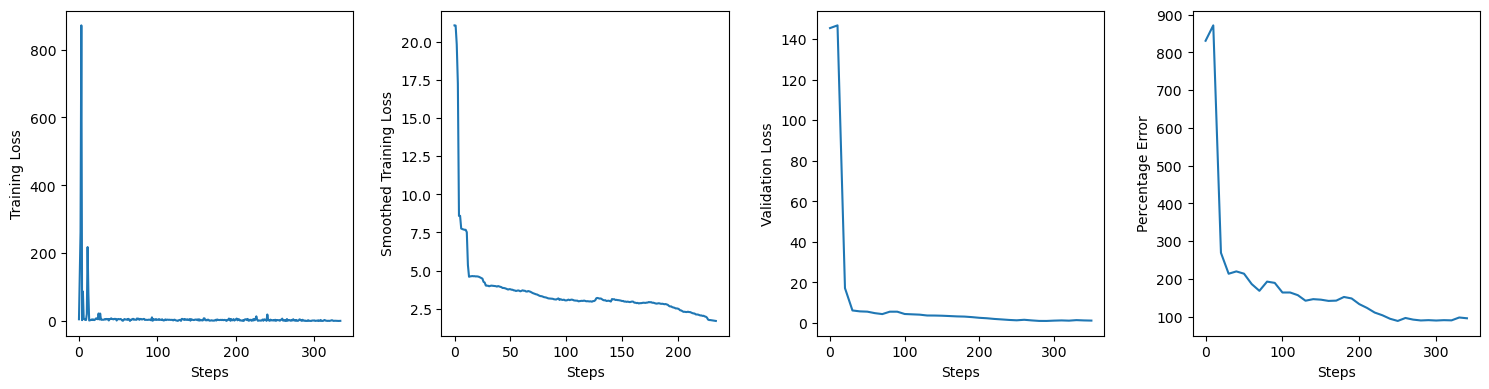

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size_phyto = len(clusters)
input_size_abio = len(abio_columns)
lstm_hidden_size = input_size_phyto - 1
ffnn_hidden_size = max(input_size_abio - 3, 5) - 1
output_size = input_size_phyto
p_drop = 0.1
bidirectional = False

trial_name = "Optimal_Parameter_Test"
shuffled_rows = True
random_seed = 2
train_ratio = 0.7
minimum_lookback = 10
lookback = -1
loss_metric = "MSE"
lr = 0.01
epochs = 1
check_interval = 10

# for now we just train for DANTZGT
data = location_data_dict["DANTZGT"]

training_part = int(len(data) * 0.8)

test_data = data.iloc[training_part:]
data = data.iloc[:training_part]

model = PhytoPredictor(input_size_phyto, lstm_hidden_size, input_size_abio, ffnn_hidden_size, output_size, p_drop, bidirectional)

# optimiser is Adam for now, but can be changed
optimiser = Adam(model.parameters(), lr=lr)

model, training_loss_log, evaluation_loss_log, percentage_error_log = train_phytopredictor(model, 
                                                                     optimiser, 
                                                                     data, 
                                                                     trial_name, 
                                                                     abio_columns, 
                                                                     group_labels, 
                                                                     shuffled_rows, 
                                                                     random_seed, 
                                                                     train_ratio, 
                                                                     minimum_lookback, 
                                                                     lookback, 
                                                                     loss_metric,
                                                                     device,
                                                                     epochs,
                                                                     check_interval)


plot_loss(training_loss_log, evaluation_loss_log, percentage_error_log, check_interval, window_size=100)

## Phytoplankton Concentration Extrapolation

(120, 91)
(120, 11)
     ZS [mg/l]  T [oC]  SiO2 [umol/L]  SALNTT [DIMSLS]  PO4 [umol/L]  \
478       43.3    17.6       3.114286             28.3      0.761290   
479       58.4    17.8       4.035714             31.3      0.741935   
480       75.7    17.0       4.000000             26.6      0.750000   
481       93.0    13.5       3.964286             27.4      0.758065   
482      127.0     8.0      12.857143             27.4      0.625806   

     pH [DIMSLS]  NO3 [umol/L]  NO2 [umol/L]  NH4 [umol/L]   E [/m]  \
478        8.200      0.357143      0.214286      0.500000  0.70000   
479        8.070      0.357143      0.392857      0.521429  1.79000   
480        8.125      0.357143      1.482143      3.975000  1.58415   
481        8.180      0.357143      2.571429      7.428571  1.37830   
482        8.000      5.521429      2.200000     25.571429  1.11900   

     CHLFa [ug/l]  
478          32.0  
479          13.0  
480          25.0  
481          37.0  
482          16.7  


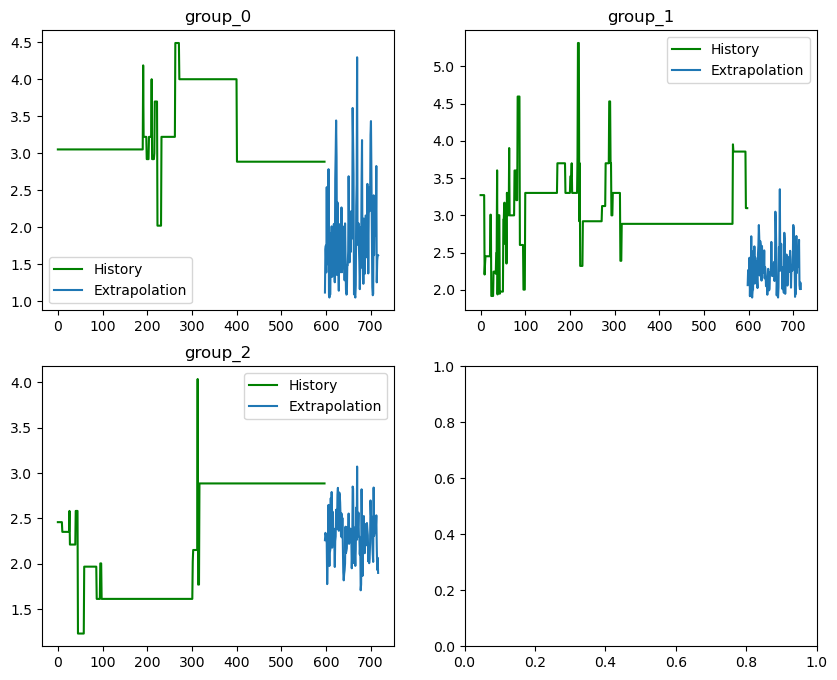

In [69]:
# abiotic_data = pd.read_csv("DANTZGT_abio_extrapolate_48.csv")
print(test_data.shape)
abiotic_data = test_data[abio_columns]

print(abiotic_data.shape)
print(abiotic_data.head())

phytoplankton_history = location_data_dict["DANTZGT"][group_labels]
print(phytoplankton_history.head())

extrapolated_data = extrapolate(model, abiotic_data, phytoplankton_history, device)

print(extrapolated_data.shape)

colcount = 2

rowcount = int(math.ceil(len(group_labels) / colcount))

fig, ax = plt.subplots(rowcount, colcount, 
                figsize=(5 * colcount, 4 * rowcount))

for i, column in enumerate(group_labels):

    extrapolated_column = extrapolated_data[:, i]

    if colcount == 1:
        subplot = ax[i // colcount]
    else:
        subplot = ax[i // colcount][i % colcount]
    
    hist_length = len(phytoplankton_history[column])

    subplot.plot(range(hist_length), phytoplankton_history[column], 'g', label="History")

    subplot.plot(range(hist_length, hist_length + len(extrapolated_column)), extrapolated_column, label="Extrapolation")
    subplot.legend()
    subplot.set_title(column)